In [1]:
# Required libraries for options trading analysis
import massive  # Polygon.io API client for market data
import pandas as pd  # Data manipulation and analysis

In [2]:
import datetime

def dateStrike2opt(edate, callPut, strike):
    """
    Generate option symbol in Polygon.io format
    
    Args:
        edate (str): Expiration date in "YYYY-MM-DD" format
        callPut (str): "C" for Call, "P" for Put
        strike (int): Strike price as integer (e.g., 450 for $450)
        useSPX (bool): If True, use SPXW symbols, else use SPY
    
    Returns:
        str: Formatted option symbol for API calls
    
    Example:
        dateStrike2opt("2023-05-19", "C", 420) -> "O:SPY230519C00420000"
    """
    # Convert date string to datetime object
    dtd = datetime.datetime.strptime(edate, "%Y-%m-%d")
    
    
    # Build option symbol: prefix + date(YYMMDD) + C/P + strike(5 digits) + "000"
    option = 'O:SPY' + dtd.strftime("%y%m%d") + callPut + str(strike).zfill(5) + "000"
    return option

In [3]:
# ==============================================================================
# DATA COLLECTION: SPY MINUTE-LEVEL DATA
# ==============================================================================
from massive import RESTClient
import os
from dotenv import load_dotenv

# Load API credentials from environment file
load_dotenv()
polygon_api_key = os.getenv("POLYGON_API_KEY")
client = RESTClient(polygon_api_key)

# Collect SPY minute-level aggregated data for the analysis period
# This will be used to identify trading opportunities and calculate features
aggs = []
for a in client.list_aggs(
    "SPY",                # SPY ETF ticker
    5,                    # 5-minute intervals
    "minute",            # Time unit
    "2022-05-01",        # Start date 
    "2025-12-31",        # End date
    adjusted="true",     # Use adjusted prices (for splits/dividends)
    sort="asc",          # Chronological order
    limit=50000,         # Max records per API call
):
    aggs.append(a)

In [4]:
# Convert aggregated data to pandas DataFrame for analysis
minute_spy_df = pd.DataFrame(aggs)

In [5]:
# Convert Unix timestamps to Eastern Time datetime objects
# Financial markets operate in Eastern Time, so this ensures proper time alignment
minute_spy_df['datetime'] = pd.to_datetime(minute_spy_df['timestamp'], unit='ms', utc=True).dt.tz_convert('America/New_York')

In [6]:
# Filter data to regular trading hours only (9:30 AM - 4:00 PM Eastern)
# This removes pre-market and after-hours data which can have different dynamics
minute_spy_df = minute_spy_df[(minute_spy_df['datetime'].dt.time >= pd.to_datetime("09:30").time()) & (minute_spy_df['datetime'].dt.time <= pd.to_datetime("16:00").time())]

In [7]:
# Sort data chronologically and reset index for clean sequential access
minute_spy_df = minute_spy_df.sort_values('datetime').reset_index(drop=True)

In [8]:
# Extract date component for daily grouping and analysis
minute_spy_df['date'] = minute_spy_df['datetime'].dt.date

In [9]:
# Calculate 2% range around daily opening price to determine relevant strike prices
# This creates a reasonable range of options to analyze (not too far OTM/ITM)
minute_spy_df['open_plus_2_pct'] = minute_spy_df.groupby('date')['open'].transform('first') * 1.02
minute_spy_df['open_minus_2_pct'] = minute_spy_df.groupby('date')['open'].transform('first') * 0.98

In [10]:
# ==============================================================================
# OPTION UNIVERSE CREATION
# ==============================================================================
# Create a comprehensive list of all options contracts needed for analysis
# For each trading day, we'll generate both calls and puts within the 2% range

options_needed = {}  # Dictionary: {option_symbol: trading_date}

for k, v in minute_spy_df.groupby('date'):
    # Get first row of each trading day (market open data)
    row = v.iloc[0]
    date = row['datetime'].strftime("%Y-%m-%d")
    edate = row['datetime'].strftime("%Y-%m-%d")  # Expiration date = same day (0DTE)
    
    # Determine strike price range based on 2% boundaries
    min_strike = int(row['open_minus_2_pct'])  # Round down for minimum
    max_strike = int(row['open_plus_2_pct']) + 1  # Round up for maximum
    
    # Generate all call and put options within the strike range
    for strike in range(min_strike, max_strike):
        call_option = dateStrike2opt(edate, "C", strike)  # Call option symbol
        put_option = dateStrike2opt(edate, "P", strike)   # Put option symbol
        
        # Store option symbols with their corresponding trading date
        options_needed[call_option] = date
        options_needed[put_option] = date

print(f"Total options to download: {len(options_needed)}")

Total options to download: 39002


In [11]:
options_needed

{'O:SPY220502C00403000': '2022-05-02',
 'O:SPY220502P00403000': '2022-05-02',
 'O:SPY220502C00404000': '2022-05-02',
 'O:SPY220502P00404000': '2022-05-02',
 'O:SPY220502C00405000': '2022-05-02',
 'O:SPY220502P00405000': '2022-05-02',
 'O:SPY220502C00406000': '2022-05-02',
 'O:SPY220502P00406000': '2022-05-02',
 'O:SPY220502C00407000': '2022-05-02',
 'O:SPY220502P00407000': '2022-05-02',
 'O:SPY220502C00408000': '2022-05-02',
 'O:SPY220502P00408000': '2022-05-02',
 'O:SPY220502C00409000': '2022-05-02',
 'O:SPY220502P00409000': '2022-05-02',
 'O:SPY220502C00410000': '2022-05-02',
 'O:SPY220502P00410000': '2022-05-02',
 'O:SPY220502C00411000': '2022-05-02',
 'O:SPY220502P00411000': '2022-05-02',
 'O:SPY220502C00412000': '2022-05-02',
 'O:SPY220502P00412000': '2022-05-02',
 'O:SPY220502C00413000': '2022-05-02',
 'O:SPY220502P00413000': '2022-05-02',
 'O:SPY220502C00414000': '2022-05-02',
 'O:SPY220502P00414000': '2022-05-02',
 'O:SPY220502C00415000': '2022-05-02',
 'O:SPY220502P00415000': 

In [12]:
# ==============================================================================
# PARALLEL DATA COLLECTION: OPTIONS PRICING DATA
# ==============================================================================
from concurrent.futures import ThreadPoolExecutor

def process_option(key, value):
    """
    Download minute-level pricing data for a single option contract
    
    Args:
        key (str): Option symbol in Polygon format
        value (str): Trading date for the option
    
    Returns:
        list: List of aggregated price data for the option
    """
    aggs = []
    try:
        # Get minute-level data for the specific trading day
        for a in client.list_aggs(
            key,                                                              # Option symbol
            5,                                                               # 5-minute intervals  
            "minute",                                                        # Time unit
            value,                                                           # Start date (trading day)
            (pd.to_datetime(value) + pd.Timedelta(days=1)).strftime("%Y-%m-%d"),  # Next day
            adjusted="true",
            sort="asc",
            limit=50000,
        ):
            # Double-check option still in our needed list (safety check)
            if key not in options_needed:
                continue
            aggs.append(a)
    except Exception as e:
        print(f"Error processing {key}: {e}")
    
    return aggs

# Download all options data using parallel processing for efficiency
options = {}
count = 0

print("Starting parallel options data download...")
with ThreadPoolExecutor() as executor:
    # Submit all download tasks to thread pool
    futures = {executor.submit(process_option, key, value): key for key, value in options_needed.items()}
    
    # Collect results as they complete
    for future in futures:
        options[futures[future]] = future.result()
        count += 1
        if count % 10 == 0:
            print(f"Processed {count / len(options_needed) * 100:.2f}% options", end="\r")

print(f"\nCompleted downloading data for {len(options)} options")

Starting parallel options data download...
Processed 99.99% options
Completed downloading data for 39002 options


In [13]:
# ==============================================================================
# DATA CONSOLIDATION: CONVERT TO MASTER DATAFRAME
# ==============================================================================
# Collect all option pricing data into a single DataFrame for analysis

# Collect all data in a list first (more memory efficient than concatenating)
data = []
count = 0

for option, aggs in options.items():
    # Skip options with no data
    if not aggs:
        continue
    
    # Extract pricing data from each aggregate record
    for agg in aggs:
        data.append({
            'option': option,           # Option symbol
            'timestamp': agg.timestamp, # Unix timestamp
            'open': agg.open,          # Opening price
            'high': agg.high,          # High price  
            'low': agg.low,            # Low price
            'close': agg.close,        # Closing price
            'volume': agg.volume       # Trading volume
        })
    count += 1
    print(f"Processed option: {option} ({count}/{len(options)})", end="\r")

# Create the master options DataFrame in one efficient operation
option_df = pd.DataFrame(data)

# Convert Unix timestamps to Eastern Time datetime objects
option_df['datetime'] = pd.to_datetime(option_df['timestamp'], unit='ms', utc=True).dt.tz_convert('America/New_York')

print(f"\nCreated master DataFrame with {len(option_df):,} rows")
option_df

Processed option: O:SPY251231P00700000 (37126/39002)
Created master DataFrame with 2,418,608 rows


,option,timestamp,open,high,low,close,volume,datetime
0,O:SPY220502C00403000,1651498800000,7.24,10.03,7.24,10.00,17,2022-05-02 09:40:00-04:00
1,O:SPY220502C00403000,1651499100000,9.16,9.29,8.55,9.29,4,2022-05-02 09:45:00-04:00
2,O:SPY220502C00403000,1651499400000,8.75,8.75,8.75,8.75,10,2022-05-02 09:50:00-04:00
3,O:SPY220502C00403000,1651499700000,10.35,10.35,10.35,10.35,1,2022-05-02 09:55:00-04:00
4,O:SPY220502C00403000,1651501200000,10.51,10.51,10.51,10.51,1,2022-05-02 10:20:00-04:00
...,...,...,...,...,...,...,...,...
2418603,O:SPY251231C00700000,1767214200000,0.01,0.01,0.01,0.01,6,2025-12-31 15:50:00-05:00
2418604,O:SPY251231C00700000,1767214500000,0.01,0.01,0.01,0.01,1,2025-12-31 15:55:00-05:00
2418605,O:SPY251231P00700000,1767211200000,16.31,16.31,16.31,16.31,1,2025-12-31 15:00:00-05:00
2418606,O:SPY251231P00700000,1767212400000,17.00,17.00,17.00,17.00,4,2025-12-31 15:20:00-05:00


In [14]:
# Merge options data with SPY underlying price data
# This links each option price observation with the corresponding SPY price
option_df = option_df.merge(minute_spy_df[['datetime', 'close']], left_on='datetime', right_on='datetime', how='left', suffixes=('', '_spy'))

In [15]:
# Calculate the At-The-Money (ATM) strike price based on SPY price
# This helps determine how far in/out of the money each option is
option_df['ATM_strike'] = option_df['close_spy'].fillna(0).astype(int)

In [16]:
# Filter options data to regular trading hours only (9:30 AM - 4:00 PM Eastern)  
# This ensures consistency with our SPY data and removes illiquid periods
option_df = option_df[(option_df['datetime'].dt.time >= pd.to_datetime("09:30").time()) & (option_df['datetime'].dt.time <= pd.to_datetime("16:00").time())]
option_df

,option,timestamp,open,high,low,close,volume,datetime,close_spy,ATM_strike
0,O:SPY220502C00403000,1651498800000,7.24,10.03,7.24,10.00,17,2022-05-02 09:40:00-04:00,412.0600,412
1,O:SPY220502C00403000,1651499100000,9.16,9.29,8.55,9.29,4,2022-05-02 09:45:00-04:00,411.5000,411
2,O:SPY220502C00403000,1651499400000,8.75,8.75,8.75,8.75,10,2022-05-02 09:50:00-04:00,412.5050,412
3,O:SPY220502C00403000,1651499700000,10.35,10.35,10.35,10.35,1,2022-05-02 09:55:00-04:00,412.2700,412
4,O:SPY220502C00403000,1651501200000,10.51,10.51,10.51,10.51,1,2022-05-02 10:20:00-04:00,413.2701,413
...,...,...,...,...,...,...,...,...,...,...
2418603,O:SPY251231C00700000,1767214200000,0.01,0.01,0.01,0.01,6,2025-12-31 15:50:00-05:00,682.5079,682
2418604,O:SPY251231C00700000,1767214500000,0.01,0.01,0.01,0.01,1,2025-12-31 15:55:00-05:00,681.8400,681
2418605,O:SPY251231P00700000,1767211200000,16.31,16.31,16.31,16.31,1,2025-12-31 15:00:00-05:00,683.6300,683
2418606,O:SPY251231P00700000,1767212400000,17.00,17.00,17.00,17.00,4,2025-12-31 15:20:00-05:00,682.9300,682


In [17]:
# Extract strike price from option symbol using regex pattern matching
# Option symbols contain strike price in positions 2-5 of an 8-digit code
option_df['strike_price'] = option_df['option'].str.extract(r'(\d{8})')[0].astype(str).str[2:5].astype(int)

In [18]:
# Calculate "moneyness" - how far the option is from At-The-Money
# Positive = In-The-Money, Negative = Out-Of-The-Money, Zero = At-The-Money
option_df['dist_from_ATM'] = (option_df['strike_price'] - option_df['ATM_strike']) / option_df['ATM_strike']

In [19]:
# Convert option prices from dollars to cents for easier integer calculations
# This avoids floating point precision issues and makes price differences more readable
option_df['close_in_cents'] = option_df['close'] * 100

In [20]:
# ==============================================================================
# FEATURE ENGINEERING: ROLLING WINDOWS & TECHNICAL INDICATORS
# ==============================================================================
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

# ==========================================
# CONFIGURATION
# ==========================================
# Define time windows for rolling calculations (in minutes)
# These capture different timeframes of price momentum and volatility
windows = [5, 10, 15, 30, 60, 120]  # 5min to 2-hour lookbacks

# Optimize CPU usage while leaving cores for system processes
n_workers = max(1, multiprocessing.cpu_count() - 3)

# Sort data for proper time-series calculations
option_df = option_df.sort_values(['option', 'datetime']).copy()

# ==========================================
# FEATURE CALCULATION FUNCTION
# ==========================================
def process_option(args):
    """
    Calculate comprehensive technical features for a single option
    
    Features calculated:
    1. Daily cumulative range position (where price sits in day's range)
    2. Rolling price changes and volatility measures
    3. Position within rolling price ranges
    4. Directional volatility (volatility weighted by price direction)
    
    Args:
        args (tuple): (option_symbol, dataframe) pair
    
    Returns:
        DataFrame: Original data with engineered features added
    """
    option, df = args
    df = df.sort_values('datetime').reset_index(drop=True)

    # ----- CUMULATIVE DAY RANGE FEATURES -----
    # Track where current price sits relative to day's cumulative high/low
    df['cum_min'] = df['close_in_cents'].cummin()  # Running minimum
    df['cum_max'] = df['close_in_cents'].cummax()  # Running maximum

    # Position in daily range (0 = at daily low, 1 = at daily high)
    df['pos_in_day_range'] = (
        (df['close_in_cents'] - df['cum_min']) /
        (df['cum_max'] - df['cum_min'])
    ).fillna(0)  # Handle division by zero on first observation

    # ----- ROLLING WINDOW FEATURES -----
    for window in windows:
        # ===== LOOKBACK PRICE COMPARISONS =====
        # Find prices exactly N minutes ago using efficient searchsorted
        target_times = df['datetime'] - pd.Timedelta(minutes=window)
        idx = df['datetime'].searchsorted(target_times, side='right') - 1
        valid_mask = idx >= 0  # Only valid if we have data N minutes ago

        # Extract historical prices (NaN where insufficient data)
        past_prices = np.full(len(df), np.nan)
        past_prices[valid_mask] = df.loc[idx[valid_mask], 'close_in_cents'].values
        df[f'close_{window}m_ago'] = past_prices

        # Calculate price change from N minutes ago
        df[f'price_change_{window}m'] = (
            df['close_in_cents'] - df[f'close_{window}m_ago']
        )

        # ===== ROLLING STATISTICS =====
        # Calculate rolling min, max, and standard deviation over window
        rolling_min = []
        rolling_max = []
        rolling_std = []

        for i in range(len(df)):
            # Define time window ending at current observation
            start_time = df.loc[i, 'datetime'] - pd.Timedelta(minutes=window)
            
            # Extract prices within the rolling window
            window_slice = df.loc[
                (df['datetime'] >= start_time) &
                (df['datetime'] <= df.loc[i, 'datetime']),
                'close_in_cents'
            ]

            # Calculate rolling statistics
            rolling_min.append(window_slice.min())
            rolling_max.append(window_slice.max())
            rolling_std.append(window_slice.std())

        # Store rolling statistics
        df[f'rolling_min_{window}m'] = rolling_min
        df[f'rolling_max_{window}m'] = rolling_max
        df[f'rolling_std_{window}m'] = rolling_std

        # ===== DERIVED FEATURES =====
        # Position within rolling range (0 = at period low, 1 = at period high)
        df[f'pos_in_rolling_range_{window}m'] = (
            (df['close_in_cents'] - df[f'rolling_min_{window}m']) /
            (df[f'rolling_max_{window}m'] - df[f'rolling_min_{window}m'])
        ).fillna(0)

        # Directional volatility: rolling std weighted by price direction
        # Positive when price moved up, negative when moved down
        df[f'directional_rolling_std_{window}m'] = (
            df[f'rolling_std_{window}m'] *
            np.sign(df[f'price_change_{window}m'])
        )

    # Clean up temporary columns
    df.drop(columns=['cum_min', 'cum_max'], inplace=True)
    return df

# ==========================================
# PARALLEL PROCESSING EXECUTION
# ==========================================
print("Starting feature engineering with multiprocessing...")
groups = list(option_df.groupby('option'))  # Group by option symbol
results = []
total = len(groups)

# Process each option's features in parallel for speed
with ProcessPoolExecutor(max_workers=n_workers) as executor:
    # Submit all feature calculation tasks
    futures = {executor.submit(process_option, g): g[0] for g in groups}
    
    # Collect results as they complete
    for i, future in enumerate(as_completed(futures)):
        results.append(future.result())
        print(f"Processed {i+1}/{total}", end="\r")

# Combine all processed options back into single DataFrame
option_df = pd.concat(results, ignore_index=True)

print(f"\n✅ Feature engineering completed! Added features for {len(windows)} time windows")
print("Features include: price changes, rolling ranges, volatility, and position indicators")

Starting feature engineering with multiprocessing...
Processed 37126/37126
✅ Feature engineering completed! Added features for 6 time windows
Features include: price changes, rolling ranges, volatility, and position indicators


In [36]:
# ==============================================================================
# TARGET VARIABLE CREATION: 3:30 PM PRICE LOOKUP 
# ==============================================================================
import pandas as pd
import numpy as np

# Define target time for profit calculation (30 minutes before market close)
target_time = pd.to_datetime("15:30").time()

# Prepare data for efficient grouping operations
option_df = option_df.sort_values(['option', 'datetime']).copy()
option_df['date'] = option_df['datetime'].dt.date
option_df['time'] = option_df['datetime'].dt.time

def assign_price_at_target(group):
    """
    Find the option price closest to 3:30 PM for each trading day
    
    This creates our target variable: we want to predict if an option
    purchased at any point during the day would be profitable by 3:30 PM
    
    Args:
        group (DataFrame): Single option on single day
        
    Returns:
        DataFrame: Group with 3:30 PM price added to all rows
    """
    # Calculate absolute time difference from target time (3:30 PM)
    group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S', errors='coerce')
    time_diff = (
        group['time'] -
        pd.to_datetime(str(target_time))
    ).abs()

    # Find the row with timestamp closest to 3:30 PM
    idx = time_diff.idxmin()
    price = group.loc[idx, 'close_in_cents']

    # Assign this price to all rows for the option-day combination
    # This enables profit calculation from any purchase time to 3:30 PM
    group['price_at_15_30'] = price
    return group

# Apply 3:30 PM price lookup to each option-day combination
option_df = (
    option_df
    .groupby(['option', 'date'], group_keys=True)
    .apply(assign_price_at_target)
    .reset_index(drop=True)
)

# Clean up temporary time column
option_df.drop(columns=['time'], inplace=True)

print("✅ 3:30 PM target prices assigned for profit calculation")
print(f"This enables predicting profitability from any intraday purchase time")

/tmp/ipykernel_24069/2692137813.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(assign_price_at_target)


✅ 3:30 PM target prices assigned for profit calculation
This enables predicting profitability from any intraday purchase time


In [37]:
# ==============================================================================
# DATA CLEANING: REMOVE INCOMPLETE RECORDS
# ==============================================================================
# Remove any rows with missing values to ensure model training stability
# This step is crucial after merging datasets and calculating rolling features
# Any NaN values could indicate:
# - Options with insufficient trading history for rolling calculations
# - Failed merges between options and underlying SPY data
# - Missing price data from API calls

option_df = option_df.dropna()

print(f"✅ Data cleaning completed")
print(f"Final dataset size: {len(option_df):,} observations")
print(f"Unique options: {option_df['option'].nunique():,}")
print(f"Date range: {option_df['datetime'].min().date()} to {option_df['datetime'].max().date()}")

✅ Data cleaning completed
Final dataset size: 1,335,673 observations
Unique options: 35,576
Date range: 2022-05-02 to 2025-12-31


In [38]:
# ==============================================================================
# OPTION TYPE CLASSIFICATION
# ==============================================================================
# Create binary indicator for option type:
# - Calls (C): Bullish instruments, profit when underlying price rises
# - Puts (P): Bearish instruments, profit when underlying price falls
# This will be used as a feature in our machine learning model

option_df['side'] = np.where(option_df['option'].str.contains('C'), 'call', 'put')

print("Option type distribution:")
print(option_df['side'].value_counts())
print(f"Call options: {(option_df['side'] == 'call').sum():,}")
print(f"Put options: {(option_df['side'] == 'put').sum():,}")

Option type distribution:
side
put     691551
call    644122
Name: count, dtype: int64
Call options: 644,122
Put options: 691,551


In [39]:
# ==============================================================================
# BINARY PROFIT TARGET CREATION
# ==============================================================================
# Create our main prediction target: binary profitability by 3:30 PM
# This answers the question: "If I buy this option now, will it be profitable by 3:30 PM?"
# 
# Target Definition:
# - 1 (profitable): Option price at 3:30 PM > current purchase price
# - 0 (unprofitable): Option price at 3:30 PM <= current purchase price
#
# This creates a classification problem suitable for machine learning models

option_df['profit_15_30'] = (option_df['price_at_15_30'] - option_df['close_in_cents'] > 0).astype(int)

# Display target variable statistics
profit_rate = option_df['profit_15_30'].mean()
print(f"Overall profitability rate: {profit_rate:.2%}")
print(f"Profitable trades: {option_df['profit_15_30'].sum():,}")
print(f"Unprofitable trades: {(option_df['profit_15_30'] == 0).sum():,}")

# Check distribution by option type
print("\nProfitability by option type:")
profit_by_type = option_df.groupby('side')['profit_15_30'].agg(['count', 'mean'])
print(profit_by_type)

Overall profitability rate: 25.27%
Profitable trades: 337,553
Unprofitable trades: 998,120

Profitability by option type:
       count      mean
side                  
call  644122  0.297248
put   691551  0.211248


In [40]:
# ==============================================================================
# INTRADAY TIMING FEATURES
# ==============================================================================
# Create time-based features to capture intraday patterns in options trading
# Options often exhibit different risk/return profiles depending on time of day

# Define standard market hours for reference
option_df['open_datetime'] = (option_df['datetime'].dt.normalize() + pd.Timedelta(hours=9, minutes=30)).dt.tz_convert('America/New_York')
option_df['close_datetime'] = (option_df['datetime'].dt.normalize() + pd.Timedelta(hours=16)).dt.tz_convert('America/New_York')

print("✅ Market timing reference points established:")
print("- Market open: 9:30 AM Eastern")  
print("- Market close: 4:00 PM Eastern")
print("- Analysis cutoff: 3:30 PM Eastern (30 minutes before close)")

✅ Market timing reference points established:
- Market open: 9:30 AM Eastern
- Market close: 4:00 PM Eastern
- Analysis cutoff: 3:30 PM Eastern (30 minutes before close)


In [41]:
# Calculate time progress through trading session as model features
# These capture how timing affects option pricing and profitability

# Time elapsed since market open (useful for momentum features)
option_df['seconds_since_open'] = (option_df['datetime'] - option_df['open_datetime']).dt.total_seconds()

# Time remaining until market close (useful for time decay features) 
option_df['seconds_until_close'] = (option_df['close_datetime'] - option_df['datetime']).dt.total_seconds()

print("Time-based features created:")
print(f"- Average seconds since open: {option_df['seconds_since_open'].mean():,.0f}")
print(f"- Average seconds until close: {option_df['seconds_until_close'].mean():,.0f}")
print(f"- Time range: {option_df['seconds_since_open'].min()/3600:.1f}h to {option_df['seconds_since_open'].max()/3600:.1f}h since open")

Time-based features created:
- Average seconds since open: 14,260
- Average seconds until close: 9,140
- Time range: 2.0h to 6.0h since open


In [42]:
# ==============================================================================
# INTRADAY PERFORMANCE TRACKING
# ==============================================================================
# Calculate how much each option has moved since market open
# This captures the cumulative performance of options throughout the trading day
# Useful for identifying momentum patterns and mean reversion opportunities

option_df['option_ret_from_open'] = option_df['close_in_cents'] - option_df.groupby(['option', 'date'])['close_in_cents'].transform('first')

print("✅ Intraday return tracking enabled")
print(f"Average intraday return: {option_df['option_ret_from_open'].mean():.1f} cents")
print(f"Intraday volatility (std): {option_df['option_ret_from_open'].std():.1f} cents")

✅ Intraday return tracking enabled
Average intraday return: -5.5 cents
Intraday volatility (std): 123.4 cents


# 🚀 Machine Learning Model Setup

## Feature Engineering Complete ✅

We've now completed the comprehensive feature engineering pipeline:

### 📊 **Data Sources**
- **SPY Minute Data**: Underlying ETF prices (5-minute intervals)
- **Options Data**: 0DTE SPY options within ±2% of opening price
- **Time Period**: 2022-2025 (multi-year training set)

### 🔧 **Feature Categories**
1. **Price Features**: Current option price, position in daily/rolling ranges
2. **Technical Indicators**: Rolling mins/maxs, volatility measures across multiple timeframes
3. **Momentum Features**: Price changes over 5m, 10m, 15m, 30m, 1h, 2h periods
4. **Directional Volatility**: Volatility weighted by price direction
5. **Timing Features**: Time since market open, time until close
6. **Performance Features**: Option returns since market open
7. **Moneyness**: Distance from At-The-Money (side-aware for calls vs puts)

### 🎯 **Target Variable**
- **Binary Classification**: Will option be profitable by 3:30 PM?
- **Prediction Horizon**: 30 minutes before market close
- **Success Definition**: Exit price > entry price

---

## 🤖 Next Steps: Model Training & Validation

In [43]:
# ==============================================================================
# MODEL TRAINING FEATURES DEFINITION
# ==============================================================================
# Define the complete set of features for machine learning model training
# Features are organized by category for interpretability and maintenance

train_columns = [
    # OPTION CHARACTERISTICS
    'side_aware_dist_from_ATM',   # How far from ATM (calls +, puts -)
    'close_in_cents',             # Current option price
    
    # INTRADAY POSITION FEATURES  
    'pos_in_day_range',           # Position in daily price range (0-1)
    
    # 5-MINUTE LOOKBACK FEATURES
    'close_5m_ago', 'price_change_5m', 'rolling_min_5m', 'rolling_max_5m', 
    'rolling_std_5m', 'pos_in_rolling_range_5m', 'directional_rolling_std_5m',
    
    # 10-MINUTE LOOKBACK FEATURES  
    'close_10m_ago', 'price_change_10m', 'rolling_min_10m', 'rolling_max_10m',
    'rolling_std_10m', 'pos_in_rolling_range_10m', 'directional_rolling_std_10m',
    
    # 15-MINUTE LOOKBACK FEATURES
    'close_15m_ago', 'price_change_15m', 'rolling_min_15m', 'rolling_max_15m', 
    'rolling_std_15m', 'pos_in_rolling_range_15m', 'directional_rolling_std_15m',
    
    # 30-MINUTE LOOKBACK FEATURES
    'close_30m_ago', 'price_change_30m', 'rolling_min_30m', 'rolling_max_30m',
    'rolling_std_30m', 'pos_in_rolling_range_30m', 'directional_rolling_std_30m',
    
    # 1-HOUR LOOKBACK FEATURES
    'close_60m_ago', 'price_change_60m', 'rolling_min_60m', 'rolling_max_60m', 
    'rolling_std_60m', 'pos_in_rolling_range_60m', 'directional_rolling_std_60m',
    
    # 2-HOUR LOOKBACK FEATURES  
    'close_120m_ago', 'price_change_120m', 'rolling_min_120m', 'rolling_max_120m',
    'rolling_std_120m', 'pos_in_rolling_range_120m', 'directional_rolling_std_120m',
    
    # TIMING FEATURES
    'seconds_since_open',         # Time elapsed since 9:30 AM
    'seconds_until_close',        # Time remaining until 4:00 PM  
    
    # PERFORMANCE FEATURES
    'option_ret_from_open'        # Cumulative return since market open
]

print(f"📊 Model training features defined: {len(train_columns)} total")
print("Feature categories:")
print("- Option characteristics: 2 features")  
print("- Position indicators: 1 feature")
print("- Multi-timeframe lookbacks: 42 features (6 timeframes × 7 metrics)")
print("- Timing features: 2 features") 
print("- Performance features: 1 feature")

📊 Model training features defined: 48 total
Feature categories:
- Option characteristics: 2 features
- Position indicators: 1 feature
- Multi-timeframe lookbacks: 42 features (6 timeframes × 7 metrics)
- Timing features: 2 features
- Performance features: 1 feature


In [44]:
# ==============================================================================
# TIME SERIES VALIDATION SETUP
# ==============================================================================
# Extract year for walk-forward validation to prevent data leakage
# We'll train on historical years and test on future years sequentially

option_df['year'] = option_df['datetime'].dt.year

print("Dataset year distribution:")
year_counts = option_df['year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"  {year}: {count:,} observations")
print(f"\n✅ Ready for chronological walk-forward validation")

Dataset year distribution:
  2022: 166,383 observations
  2023: 333,239 observations
  2024: 368,453 observations
  2025: 467,598 observations

✅ Ready for chronological walk-forward validation


In [45]:
# ==============================================================================
# REGRESSION TARGET: PERCENTAGE GAIN
# ==============================================================================
# Create continuous target for potential regression modeling
# This complements our binary classification target

option_df['pct_gain_15_30'] = (option_df['price_at_15_30'] - option_df['close_in_cents']) / option_df['close_in_cents']

print("Percentage gain statistics:")
print(f"  Mean: {option_df['pct_gain_15_30'].mean():.3f}")
print(f"  Median: {option_df['pct_gain_15_30'].median():.3f}")
print(f"  Std Dev: {option_df['pct_gain_15_30'].std():.3f}")
print(f"  Min: {option_df['pct_gain_15_30'].min():.3f}")
print(f"  Max: {option_df['pct_gain_15_30'].max():.3f}")

Percentage gain statistics:
  Mean: -0.036
  Median: -0.111
  Std Dev: 3.446
  Min: -0.999
  Max: 364.000


In [46]:
# ==============================================================================
# SIDE-AWARE MONEYNESS FEATURE
# ==============================================================================
# Create unified moneyness metric that accounts for call vs put directionality
# For calls: positive = in-the-money (strike < spot), negative = out-of-the-money
# For puts: positive = in-the-money (strike > spot), negative = out-of-the-money
# This allows model to treat calls and puts symmetrically

option_df['side_aware_dist_from_ATM'] = option_df['dist_from_ATM'] * np.where(option_df['side'] == 'call', 1, -1)

print("Side-aware moneyness distribution:")
print(f"  Mean: {option_df['side_aware_dist_from_ATM'].mean():.4f}")
print(f"  25th percentile: {option_df['side_aware_dist_from_ATM'].quantile(0.25):.4f}")
print(f"  Median: {option_df['side_aware_dist_from_ATM'].median():.4f}")  
print(f"  75th percentile: {option_df['side_aware_dist_from_ATM'].quantile(0.75):.4f}")
print("\n✅ Unified moneyness feature created for calls and puts")

Side-aware moneyness distribution:
  Mean: 0.0025
  25th percentile: -0.0052
  Median: 0.0024
  75th percentile: 0.0104

✅ Unified moneyness feature created for calls and puts


In [47]:
# ==============================================================================
# FINAL TIME FILTER: ENSURE PREDICTION VIABILITY
# ==============================================================================
# Remove any observations after 3:30 PM to ensure we only train on viable prediction times
# We can't predict 3:30 PM profitability if we're already past 3:30 PM

pre_filter_count = len(option_df)
option_df = option_df[option_df['datetime'].dt.time <= pd.to_datetime("15:30").time()]
post_filter_count = len(option_df)

print(f"🕕 Time filter applied (observations <= 3:30 PM)")
print(f"  Records removed: {pre_filter_count - post_filter_count:,}")
print(f"  Final dataset size: {post_filter_count:,}")
print(f"  Latest observation time: {option_df['datetime'].dt.time.max()}")

🕕 Time filter applied (observations <= 3:30 PM)
  Records removed: 0
  Final dataset size: 1,335,673
  Latest observation time: 15:30:00


In [48]:
# ==============================================================================
# NUMERIC SIDE ENCODING FOR MODELING
# ==============================================================================
# Convert option side to numeric encoding for machine learning algorithms
# Calls = 1 (bullish), Puts = -1 (bearish)

option_df['side_int'] = option_df['option'].apply(lambda x: 1 if 'C' in x else -1)

print("Option side encoding:")
print(f"  Calls (1): {(option_df['side_int'] == 1).sum():,} observations")
print(f"  Puts (-1): {(option_df['side_int'] == -1).sum():,} observations")
print(f"  Balance ratio: {(option_df['side_int'] == 1).sum() / (option_df['side_int'] == -1).sum():.2f}")

Option side encoding:
  Calls (1): 644,122 observations
  Puts (-1): 691,551 observations
  Balance ratio: 0.93


In [49]:
# ==============================================================================
# FEATURE CORRELATION ANALYSIS
# ==============================================================================
# Analyze which features have strongest correlation with profitability
# Using Spearman correlation to capture non-linear relationships

print("🔍 Top features correlated with profit (Spearman correlation):")
print("=" * 80)

correlations = option_df[train_columns + ['profit_15_30']].corr(method='spearman')['profit_15_30'].sort_values(ascending=False)

# Display top positive correlations
print("📈 MOST PREDICTIVE OF PROFIT:")
for feature, corr in correlations.head(10).items():
    if feature != 'profit_15_30':
        print(f"  {feature:.<40} {corr:>+7.4f}")

print("\n📉 MOST PREDICTIVE OF LOSS:")  
# Display top negative correlations
for feature, corr in correlations.tail(10).items():
    if feature != 'profit_15_30':
        print(f"  {feature:.<40} {corr:>+7.4f}")

print("\n✅ Feature correlation analysis complete")

# Return the full correlation series for inspection
correlations

🔍 Top features correlated with profit (Spearman correlation):
📈 MOST PREDICTIVE OF PROFIT:
  close_5m_ago............................ +0.4134
  rolling_max_5m.......................... +0.4132
  rolling_min_5m.......................... +0.4132
  rolling_max_10m......................... +0.4131
  rolling_min_10m......................... +0.4130
  rolling_max_15m......................... +0.4129
  rolling_min_15m......................... +0.4127
  close_in_cents.......................... +0.4126
  close_10m_ago........................... +0.4126

📉 MOST PREDICTIVE OF LOSS:
  directional_rolling_std_30m............. +0.0143
  seconds_until_close..................... +0.0141
  price_change_15m........................ +0.0140
  directional_rolling_std_15m............. +0.0091
  price_change_10m........................ +0.0076
  directional_rolling_std_10m............. +0.0048
  price_change_5m......................... +0.0028
  directional_rolling_std_5m.............. +0.0028
  seconds_sinc

profit_15_30                    1.000000
close_5m_ago                    0.413430
rolling_max_5m                  0.413222
rolling_min_5m                  0.413210
rolling_max_10m                 0.413144
rolling_min_10m                 0.413050
rolling_max_15m                 0.412884
rolling_min_15m                 0.412748
close_in_cents                  0.412645
close_10m_ago                   0.412586
rolling_max_30m                 0.411673
close_15m_ago                   0.411632
rolling_min_30m                 0.411583
rolling_min_60m                 0.409411
close_30m_ago                   0.408416
rolling_max_60m                 0.408344
rolling_min_120m                0.405438
close_60m_ago                   0.400963
rolling_max_120m                0.399459
close_120m_ago                  0.383622
rolling_std_30m                 0.383094
rolling_std_15m                 0.379786
rolling_std_60m                 0.379150
rolling_std_10m                 0.373691
rolling_std_120m

# 🎯 Model Training & Validation

## Walk-Forward Time Series Validation

To prevent data leakage and ensure realistic performance estimates, we implement **walk-forward validation**:

### 📅 **Validation Strategy**
- **Training**: Use all historical years available  
- **Testing**: Predict on next chronological year
- **No Future Information**: Strictly chronological split
- **Realistic Simulation**: Mimics live trading conditions

### 🧠 **Model Architecture**
- **Algorithm**: XGBoost (Gradient Boosted Trees)
- **Task**: Binary Classification (Profitable vs Unprofitable)
- **Features**: 48 engineered features across multiple timeframes
- **Target**: Will option be profitable by 3:30 PM?

### 📊 **Expected Outputs**
- Year-by-year performance metrics
- Overall out-of-sample accuracy and AUC
- Feature importance analysis
- Model calibration assessment

---

In [50]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

def walk_forward_xgb_classification(
    option_df: pd.DataFrame,
    train_cols: list,
    target_col: str,
    year_col: str = "year",
    xgb_params: dict = None
):
    """
    Perform walk-forward validation for time series classification.
    
    This function implements proper time series validation by training on historical
    data and testing on future periods, preventing data leakage that could lead
    to overly optimistic performance estimates.
    
    Process:
    1. Sort data chronologically by year
    2. For each year, train on all previous years
    3. Test on current year
    4. Accumulate predictions for final evaluation
    
    Args:
        option_df (pd.DataFrame): Complete dataset with features and targets
        train_cols (list): List of feature column names for training
        target_col (str): Target variable column name
        year_col (str): Column containing year for chronological splitting
        xgb_params (dict): XGBoost hyperparameters (optional)
    
    Returns:
        pd.DataFrame: Test data with predictions and probabilities added
    """
    df = option_df.copy()
    df = df.sort_values(year_col)

    # Default XGBoost parameters optimized for options prediction
    if xgb_params is None:
        xgb_params = {
            "n_estimators": 300,           # Number of boosting rounds
            "max_depth": 4,                # Tree depth (prevent overfitting)
            "learning_rate": 0.05,         # Conservative learning rate
            'min_child_weight': 15,        # Minimum samples per leaf
            "subsample": 0.8,              # Row sampling (regularization)
            "colsample_bytree": 0.8,       # Column sampling (regularization)
            "random_state": 42,            # Reproducibility
            "use_label_encoder": False,
            "eval_metric": "logloss"       # Optimization metric
        }

    years = sorted(df[year_col].unique())
    all_results = []

    print("\n🚀 WALK FORWARD VALIDATION")
    print("="*50)

    for i in range(1, len(years)):
        train_years = years[:i]          # All historical years
        test_year = years[i]             # Current prediction year

        train_df = df[df[year_col].isin(train_years)]
        test_df = df[df[year_col] == test_year]

        if train_df.empty or test_df.empty:
            continue

        # Prepare features and targets
        X_train = train_df[train_cols]
        y_train = train_df[target_col]
        X_test = test_df[train_cols]
        y_test = test_df[target_col]

        # Train XGBoost model
        model = XGBClassifier(**xgb_params)
        model.fit(X_train, y_train)

        # Generate predictions
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]

        # Calculate performance metrics
        acc = accuracy_score(y_test, preds)

        try:
            auc = roc_auc_score(y_test, probs)
        except:
            auc = np.nan

        # Display fold results
        print(f"\n📊 Train Years: {train_years}")
        print(f"📅 Test Year: {test_year}")
        print(f"🎯 Accuracy: {acc:.4f}")
        print(f"📈 AUC: {auc:.4f}")
        print(f"🔢 Test Samples: {len(test_df):,}")

        # Store results for aggregation
        fold_results = test_df.copy()
        fold_results["prediction"] = preds
        fold_results["probability"] = probs
        fold_results["train_years"] = str(train_years)

        all_results.append(fold_results)

    # Combine all out-of-sample predictions
    results_df = pd.concat(all_results).sort_index()

    print("\n" + "="*50)
    print("🏆 FINAL OUT-OF-SAMPLE PERFORMANCE")
    print("="*50)

    # Calculate comprehensive performance metrics
    overall_acc = accuracy_score(results_df[target_col], results_df["prediction"])
    overall_auc = roc_auc_score(results_df[target_col], results_df["probability"])

    print(f"🎯 Overall Accuracy: {overall_acc:.4f}")
    print(f"📈 Overall AUC: {overall_auc:.4f}")
    print(f"📊 Total Test Samples: {len(results_df):,}")
    print(f"✅ Profit Rate Actual: {results_df[target_col].mean():.4f}")
    print(f"📊 Profit Rate Predicted: {results_df['prediction'].mean():.4f}")
    print("="*50)

    return results_df

In [51]:
# ==============================================================================
# MODEL TRAINING EXECUTION
# ==============================================================================
# Execute walk-forward validation with our engineered features
# This will provide realistic out-of-sample performance estimates

print("🚀 Starting XGBoost walk-forward validation...")
print(f"📊 Training features: {len(train_columns)}")
print(f"🎯 Target variable: profit_15_30")
print(f"📅 Time periods: {option_df['year'].min()} - {option_df['year'].max()}")

res_df = walk_forward_xgb_classification(
    option_df=option_df,
    train_cols=train_columns,
    target_col='profit_15_30',
    year_col='year'
)

print("\n✅ Model training completed! Results stored in 'res_df'")

🚀 Starting XGBoost walk-forward validation...
📊 Training features: 48
🎯 Target variable: profit_15_30
📅 Time periods: 2022 - 2025

🚀 WALK FORWARD VALIDATION


/home/mrmath/Downloads/vwap_model_/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:58:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Train Years: [np.int32(2022)]
📅 Test Year: 2023
🎯 Accuracy: 0.7443
📈 AUC: 0.7845
🔢 Test Samples: 333,239


/home/mrmath/Downloads/vwap_model_/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:58:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Train Years: [np.int32(2022), np.int32(2023)]
📅 Test Year: 2024
🎯 Accuracy: 0.7579
📈 AUC: 0.7917
🔢 Test Samples: 368,453


/home/mrmath/Downloads/vwap_model_/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:58:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Train Years: [np.int32(2022), np.int32(2023), np.int32(2024)]
📅 Test Year: 2025
🎯 Accuracy: 0.7541
📈 AUC: 0.7893
🔢 Test Samples: 467,598

🏆 FINAL OUT-OF-SAMPLE PERFORMANCE
🎯 Overall Accuracy: 0.7525
📈 Overall AUC: 0.7884
📊 Total Test Samples: 1,169,290
✅ Profit Rate Actual: 0.2474
📊 Profit Rate Predicted: 0.1361

✅ Model training completed! Results stored in 'res_df'


🔍 Analyzing model calibration...


/tmp/ipykernel_24069/4024076381.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df.groupby("bin").agg(
/tmp/ipykernel_24069/4024076381.py:88: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_24069/4024076381.py:88: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_24069/4024076381.py:88: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_24069/4024076381.py:88: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mrmath/Downloads/vwap_model_/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarni

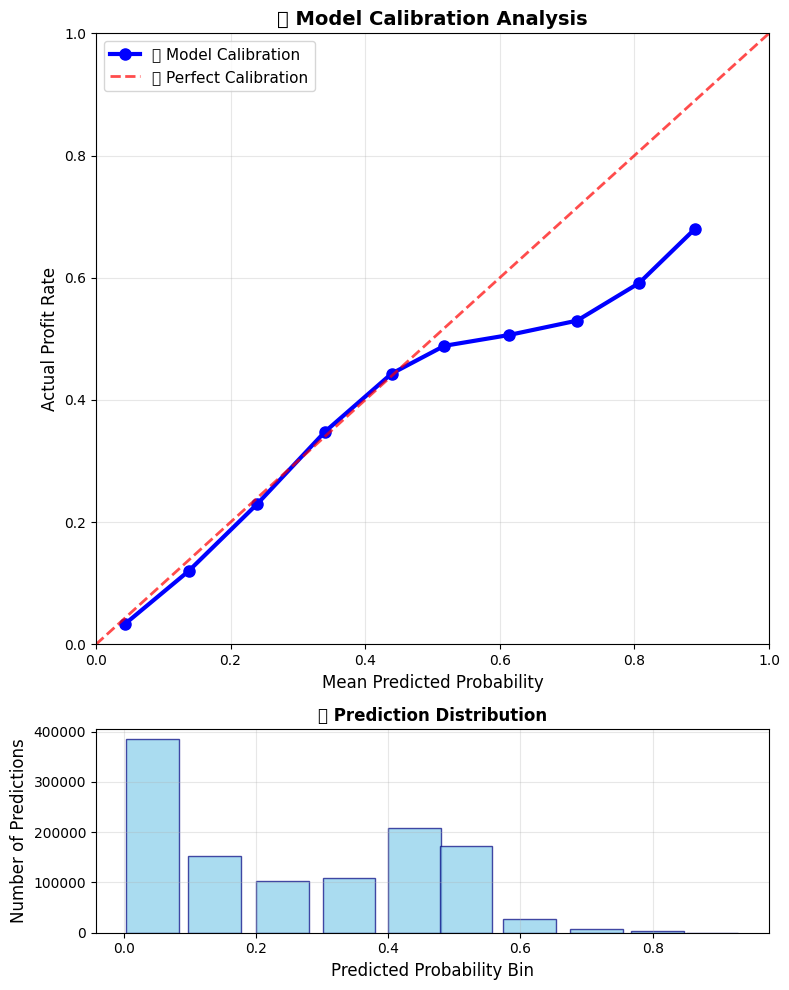


📊 CALIBRATION SUMMARY:
📈 Model generates predictions across 10 probability bins
🎯 Perfect calibration = predictions align with diagonal line
📊 Distribution shows where model makes most predictions


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_calibration_curve(res_df, n_bins=10):
    """
    Create calibration curve to assess model probability accuracy.
    
    A calibration curve shows if predicted probabilities match actual outcomes.
    Perfect calibration means when model predicts 70% probability, 
    the event occurs 70% of the time.
    
    Args:
        res_df (pd.DataFrame): Results dataframe with 'probability' and target columns
        n_bins (int): Number of bins for grouping predictions
    
    Returns:
        pd.DataFrame: Calibration statistics by prediction bin
    """
    predicted = res_df['probability']
    actual = res_df['profit_15_30']  # Binary target (0/1)

    df = pd.DataFrame({
        "predicted": predicted,
        "actual": actual
    })

    # Create equal-width probability bins
    df["bin"] = pd.cut(df["predicted"], bins=n_bins)

    # Calculate actual vs predicted rates per bin
    calibration = df.groupby("bin").agg(
        mean_predicted=("predicted", "mean"),    # Average predicted probability
        mean_actual=("actual", "mean"),          # Actual success rate
        count=("actual", "size")                 # Number of observations
    ).dropna()

    # Use mean predicted probability as bin center
    calibration["bin_center"] = calibration["mean_predicted"]

    # Create visualization with two subplots
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(8, 10),
        gridspec_kw={'height_ratios': [3, 1]}
    )

    # ----------------------------------------
    # CALIBRATION CURVE (Main Plot)
    # ---------------------------------------- 
    ax1.plot(calibration["mean_predicted"],
             calibration["mean_actual"],
             marker='o',
             linewidth=3,
             markersize=8,
             label="📊 Model Calibration",
             color='blue')

    ax1.plot([0, 1], [0, 1],
             linestyle='--',
             linewidth=2,
             label="🎯 Perfect Calibration",
             color='red',
             alpha=0.7)

    ax1.set_xlabel("Mean Predicted Probability", fontsize=12)
    ax1.set_ylabel("Actual Profit Rate", fontsize=12)
    ax1.set_title("📈 Model Calibration Analysis", fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    # ----------------------------------------
    # PREDICTION FREQUENCY (Bottom Plot)
    # ----------------------------------------
    ax2.bar(calibration["bin_center"],
            calibration["count"],
            width=1/n_bins * 0.8,
            alpha=0.7,
            color='skyblue',
            edgecolor='navy')

    ax2.set_xlabel("Predicted Probability Bin", fontsize=12)
    ax2.set_ylabel("Number of Predictions", fontsize=12)
    ax2.set_title("🔢 Prediction Distribution", fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n📊 CALIBRATION SUMMARY:")
    print("="*50)
    print(f"📈 Model generates predictions across {len(calibration)} probability bins")
    print(f"🎯 Perfect calibration = predictions align with diagonal line")
    print(f"📊 Distribution shows where model makes most predictions")
    
    return calibration

# ==========================================
# EXECUTE CALIBRATION ANALYSIS  
# ==========================================
print("🔍 Analyzing model calibration...")
calibration_df = plot_calibration_curve(res_df, n_bins=10)

In [53]:
# ==============================================================================
# RESULTS EXPORT
# ==============================================================================
# Save complete results for further analysis, backtesting, and model deployment

output_file = 'option_model_results.csv'
res_df.to_csv(output_file, index=False)

print(f"💾 Results saved to: {output_file}")
print(f"📊 Saved {len(res_df):,} predictions")
print(f"🗃️ Includes: predictions, probabilities, features, and actuals")
print(f"📅 Date range: {res_df['datetime'].min()} to {res_df['datetime'].max()}")
print(f"✅ Ready for production deployment or further analysis!")

💾 Results saved to: option_model_results.csv
📊 Saved 1,169,290 predictions
🗃️ Includes: predictions, probabilities, features, and actuals
📅 Date range: 2023-01-03 11:30:00-05:00 to 2025-12-31 15:30:00-05:00
✅ Ready for production deployment or further analysis!
